## Praca domowa 2

### Nikola Miszalska

#### TODO:
- Przygotować dane
- podzielić na zbiory treningowy, walidacyjny i testowy
- Przetestować Random Forest oraz XGBoost na przykładowych zadaniach regresji i klasyfikacji
-  Dla każdego z problemów należy wyszkolić oba modele porównując uzyskane przez nie wyniki np. accuracy/rmse na zbiorze walidacyjnym
- dla każdego modelu należy przetestować kilka różnych zestawów hiperparametrów, takich jak np. n_estimators, max_depth i omówić ich wpływ na generalizacje modelu.

#### Ładowanie bibliotek:

In [12]:
import pandas as pd
import math
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler ,PolynomialFeatures,minmax_scale,MaxAbsScaler ,LabelEncoder

from tqdm.notebook import tqdm

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

from xgboost import XGBRegressor

In [13]:
air_test = pd.read_csv("data/test.csv")
air_train = pd.read_csv("data/train.csv")
car_train = pd.read_csv("data/Car_Prices_Poland.csv")

## Zbiór danych airline_passenger_satisfaction

#### Przygotowanie danych

In [14]:
air_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

Mamy braki danych w kolumnie Arrival Delay in Minutes, jednak jest ich bardzo mało.

In [15]:
air_train.isna().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [16]:
air_train["Arrival Delay in Minutes"] = air_train["Arrival Delay in Minutes"].fillna(air_train["Arrival Delay in Minutes"].mean())

In [17]:
air_test["Arrival Delay in Minutes"] = air_test["Arrival Delay in Minutes"].fillna(air_test["Arrival Delay in Minutes"].mean())

In [18]:
air_train.head()


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [19]:
for col in ['Flight Distance','Age','Departure Delay in Minutes', 'Arrival Delay in Minutes']:
    transf = air_train[col].values.reshape(-1,1)
    scaler = StandardScaler().fit(transf)
    air_train[col] = scaler.transform(transf)
    transf = air_test[col].values.reshape(-1,1)
    air_test[col] = scaler.transform(transf)

In [20]:
air_train["Class"].unique()

array(['Eco Plus', 'Business', 'Eco'], dtype=object)

In [21]:
air_train["satisfaction"].unique()

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

In [22]:
air_train['Gender'] = (air_train['Gender'] == 'Female')*1
air_train['Customer Type'] = (air_train['Customer Type'] == 'Loyal Customer')*1
air_train["Type of Travel"] = (air_train["Type of Travel"]=='Personal Travel')*1
air_train["satisfaction"] = (air_train["satisfaction"] == "satisfied")*1

In [23]:
air_test['Gender'] = (air_test['Gender'] == 'Female')*1
air_test['Customer Type'] = (air_test['Customer Type'] == 'Loyal Customer')*1
air_test["Type of Travel"] = (air_test["Type of Travel"]=='Personal Travel')*1
air_test["satisfaction"] = (air_test["satisfaction"] == "satisfied")*1

In [24]:
air_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,0,1,-1.745279,1,Eco Plus,-0.731539,3,4,...,5,4,3,4,4,5,5,0.266393,0.073014,0
1,1,5047,0,0,-0.951360,0,Business,-0.957184,3,2,...,1,1,5,3,1,4,1,-0.361375,-0.237539,0
2,2,110028,1,1,-0.885200,0,Business,-0.047584,2,2,...,5,4,3,4,4,4,5,-0.387532,-0.392816,1
3,3,24026,1,1,-0.951360,0,Business,-0.629246,2,5,...,2,2,5,3,1,4,2,-0.099805,-0.159901,0
4,4,119299,0,1,1.430397,0,Business,-0.978244,3,3,...,3,3,4,4,3,3,3,-0.387532,-0.392816,1


Usuwam nieistotne kolumny.

In [25]:
air_train = air_train.drop(["Unnamed: 0","id"], axis=1)

In [26]:
air_test = air_test.drop(["Unnamed: 0","id"], axis=1)

In [27]:
air_test.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,1,0.834958,0,Eco,-1.032398,5,4,3,4,...,5,5,5,5,2,5,5,0.920317,0.745879,1
1,1,1,-0.223601,0,Business,1.678348,1,1,3,1,...,4,4,4,4,3,4,5,-0.387532,-0.392816,1
2,0,0,-1.282160,0,Eco,-1.000307,2,0,2,4,...,2,4,1,3,2,2,2,-0.387532,-0.392816,0
3,0,1,0.305678,0,Business,2.193821,0,0,0,2,...,1,1,1,1,3,1,4,-0.387532,-0.237539,1
4,1,1,0.636478,0,Eco,-0.007470,2,3,4,3,...,2,2,2,2,4,2,4,-0.387532,0.124773,1


In [28]:
encoded = pd.get_dummies(air_train[["Class"]].astype(str))
encoded = encoded.drop(["Class_Eco"], axis = 1)
air_train = air_train.drop(["Class"], axis=1)
air_train = pd.concat([air_train, encoded], axis = 1)

In [29]:
encoded = pd.get_dummies(air_test[["Class"]].astype(str))
encoded = encoded.drop(["Class_Eco"], axis = 1)
air_test = air_test.drop(["Class"], axis=1)
air_test = pd.concat([air_test, encoded], axis = 1)

In [30]:
air_train.head()

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Class_Business,Class_Eco Plus
0,0,1,-1.745279,1,-0.731539,3,4,3,1,5,...,3,4,4,5,5,0.266393,0.073014,0,0,1
1,0,0,-0.951360,0,-0.957184,3,2,3,3,1,...,5,3,1,4,1,-0.361375,-0.237539,0,1,0
2,1,1,-0.885200,0,-0.047584,2,2,2,2,5,...,3,4,4,4,5,-0.387532,-0.392816,1,1,0
3,1,1,-0.951360,0,-0.629246,2,5,5,5,2,...,5,3,1,4,2,-0.099805,-0.159901,0,1,0
4,0,1,1.430397,0,-0.978244,3,3,3,3,4,...,4,4,3,3,3,-0.387532,-0.392816,1,1,0


In [31]:
air_test.head()

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Class_Business,Class_Eco Plus
0,1,1,0.834958,0,-1.032398,5,4,3,4,3,...,5,5,2,5,5,0.920317,0.745879,1,0,0
1,1,1,-0.223601,0,1.678348,1,1,3,1,5,...,4,4,3,4,5,-0.387532,-0.392816,1,1,0
2,0,0,-1.282160,0,-1.000307,2,0,2,4,2,...,1,3,2,2,2,-0.387532,-0.392816,0,0,0
3,0,1,0.305678,0,2.193821,0,0,0,2,3,...,1,1,3,1,4,-0.387532,-0.237539,1,1,0
4,1,1,0.636478,0,-0.007470,2,3,4,3,4,...,2,2,4,2,4,-0.387532,0.124773,1,0,0


Podział ddanych na uczace i kolumne celu

### RandomForest i XGBoost

In [32]:
air_train["satisfaction"].value_counts()

0    58879
1    45025
Name: satisfaction, dtype: int64

In [75]:
y_train = air_train['satisfaction']
X_train = air_train.drop('satisfaction', axis = 1)

In [76]:
y_test = air_test['satisfaction']
X_test = air_test.drop('satisfaction', axis = 1)

In [35]:
rf = RandomForestClassifier(random_state=123).fit(X_train, y_train)

In [36]:
rf.score(X_train, y_train)

1.0

In [37]:
rf.score(X_test, y_test)

0.9632737911918694

### XGBoost

In [38]:
xgb_cls = xgb.XGBClassifier(objective='binary:logistic', max_depth=5, use_label_encoder=False)

In [39]:
xgb_cls.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [40]:
xgb_cls.score(X_test, y_test)

0.9633507853403142

In [41]:
xgb_cls.score(X_train, y_train)

0.9692023406221127

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

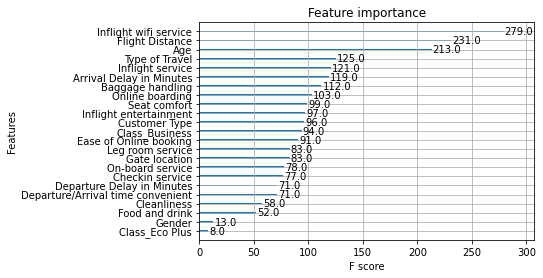

In [42]:
xgb.plot_importance(xgb_cls)

In [73]:
import shap

In [107]:
explainer = shap.TreeExplainer(xgb_cls)
shap_values = explainer.shap_values(X_test)

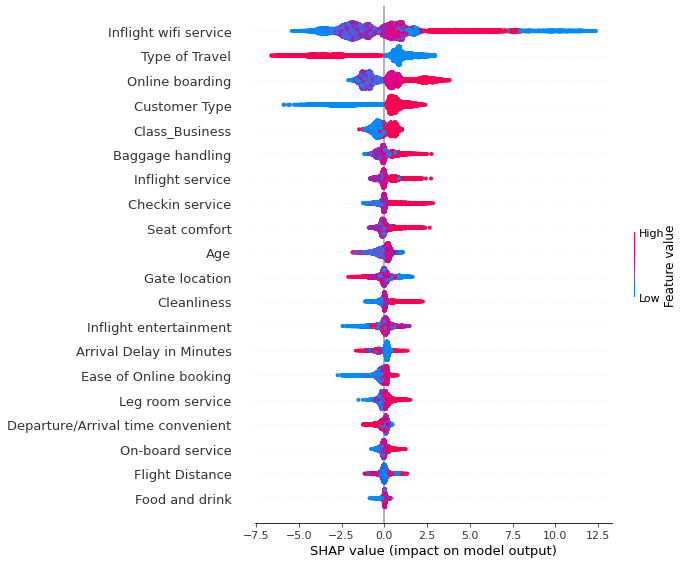

In [108]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

In [112]:
shap_values2 = explainer.shap_values(X_train)

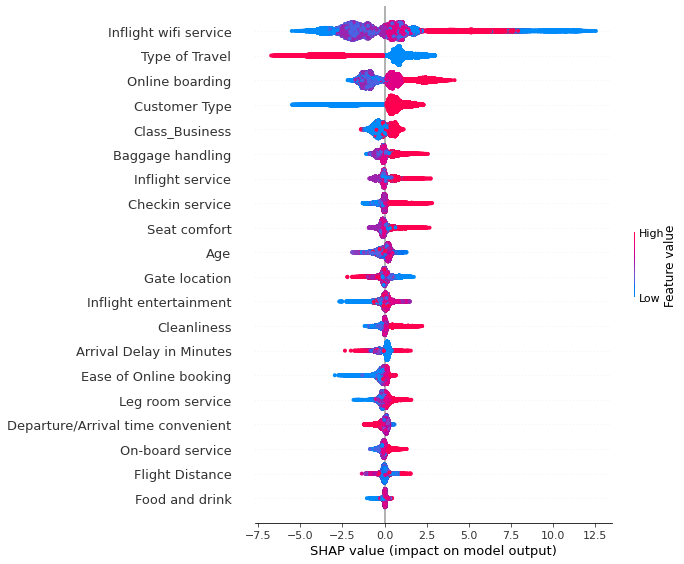

In [114]:
shap.summary_plot(shap_values2, features=X_train, feature_names=X_train.columns)

Summary plot wygląda tak samo na zbiorze testowym i treningowym, kolumny są ułożone wedłu "feature importance". Widzimy, że największy wpływ na predykcję ma Inflight wifi service, Type of travel, Online Boarding i Customer Type. Możemy również odczytać, że klient bbędzie bardziej zadowolony z podróży jesli laci w lecach prywatnych, a nie biznesowych; jesli była zadowolona z odprawy internetowej, jest lojalnym klientem. Trudno zinterpretowac wifi podczas lotu ze względu na niebieską część z prawej strony wykreu ( która teoretycznie mówi o zadowoleniu z lotu mimo średniego zadowolenia z wifi), jednak ujemny shap value jest dla słabego internetu, a dobry internet ma dodatni shap value co jest zgodne z intuicją.

In [135]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [116]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[[100]])

Tu wgl dziwnie, bo gościu był nielojalnym klientem, leciał w celach biznesowcyh a do tego miał słabe wifi i wyszło, że jest zadowolony. Chyba model nie jest zbyt dobry. ( Albo coś źle robie)

Edit: na pewno coś źle robię, przeszukałam cały internet ale nwm jak ustawić żeby było dla pojedynczego wiersza.

Z powyższych wykresów wynika, że duży wpływ na satysfakcję ma równiez opóźnienie i ilość miejsce na nogi, co nie zgadza się z summary plot.

Skorzystam teraz z dalexa.

In [156]:
import dalex as dx 
explainer2 = dx.Explainer(xgb_cls, data=X_test, y=y_test, label='treeClassif')

Preparation of a new explainer is initiated

  -> data              : 25976 rows 23 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 25976 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : treeClassif
  -> predict function  : <function yhat_proba_default at 0x0000012083BDEAF0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.04e-06, mean = 0.439, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.996, mean = 0.000197, max = 0.996
  -> model_info        : package xgboost

A new explainer has been created!


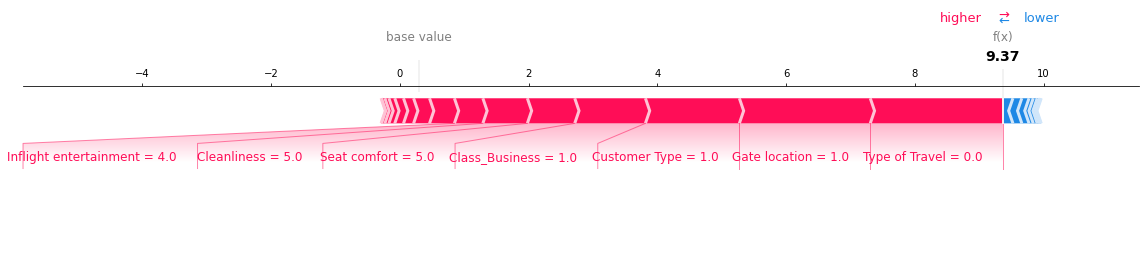

In [167]:
explainer2.predict_parts(X_test.iloc[[1]],type = "shap_wrapper",shap_explainer_type="TreeExplainer").plot()

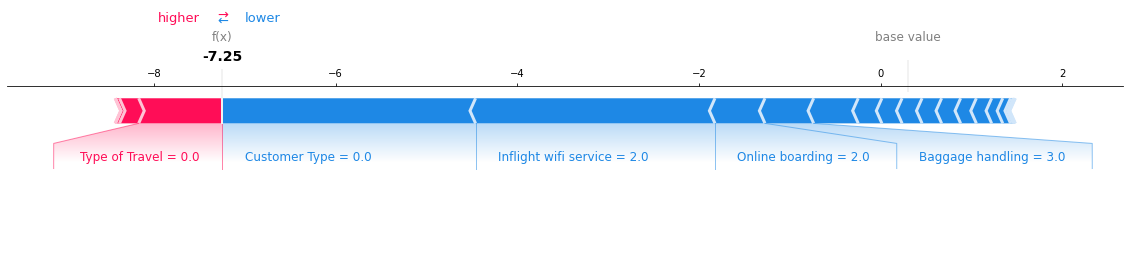

In [164]:
explainer2.predict_parts(X_test.iloc[[2]],type = "shap_wrapper",shap_explainer_type="TreeExplainer").plot()

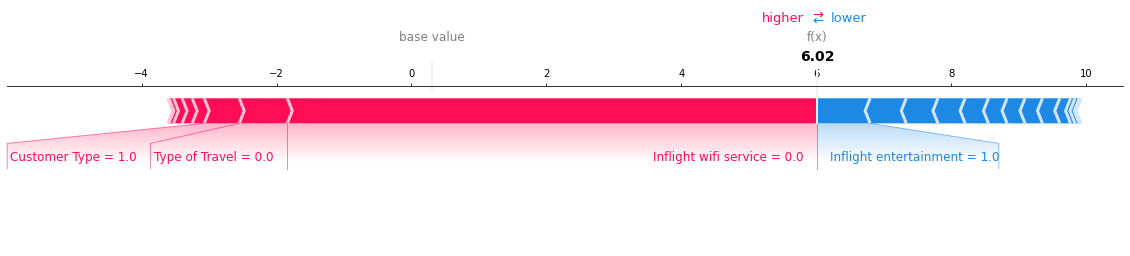

In [168]:
explainer2.predict_parts(X_test.iloc[[3]],type = "shap_wrapper",shap_explainer_type="TreeExplainer").plot()

Chyba coś jest nie tak, gościu nie miał internetu i był w sprawie biznesowej, a model ocenił go jako zadowolonego. Może dlatego że był lojalnym klientem.